In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import time
import os
import sys
import math

plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [8]:
ROOT_DIR = '/data/datasets/digit-recognizer/'
TRAIN_FILE_NAME = 'train.csv'
TEST_FILE_NAME = 'test.csv'
np.random.seed(42)
OUTPUT = []

def out_put():
    with open('output.csv', 'w') as f:
        f.write('ImageId,Label\n')
        for idx, val in enumerate(OUTPUT):
            f.write("{},{}\n".format(idx+1, val))
        print('over')        

In [9]:
data = pd.read_csv(os.path.join(ROOT_DIR, TRAIN_FILE_NAME))
test = pd.read_csv(os.path.join(ROOT_DIR, TEST_FILE_NAME)).values

In [10]:
DATA_SIZE = data.shape[0]
MASK = np.random.permutation(DATA_SIZE)
VAL_SIZE = int(math.ceil(DATA_SIZE*0.2))

## some info

### data.dtypes all int64
### data.columns

Index(['label', 'pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5',
       'pixel6', 'pixel7', 'pixel8',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
       'pixel780', 'pixel781', 'pixel782', 'pixel783'],
      dtype='object', length=785)
### data.values:

### type numpy.ndarray, dtype('int64'), shape=(42000, 785)

In [11]:
TRAIN_DATA = data.loc[MASK[VAL_SIZE:]]
VAL_DATA = data.loc[MASK[:VAL_SIZE]]
print(TRAIN_DATA.shape, VAL_DATA.shape)

(33600, 785) (8400, 785)


In [12]:
def data_label_split(data, column_name):
    labels = data.pop(column_name)
    return data, labels

In [13]:
X_train, y_train = data_label_split(TRAIN_DATA, 'label')
X_val, y_val = data_label_split(VAL_DATA, 'label')
print('X_train.shape:',X_train.shape, 'y_train.shape:', y_train.shape)
print('X_val.shape:', X_val.shape, 'y_val.shape:', y_val.shape)

X_train.shape: (33600, 784) y_train.shape: (33600,)
X_val.shape: (8400, 784) y_val.shape: (8400,)


In [14]:
X_train, y_train = X_train.values, y_train.values

In [15]:
# scale the data
# add the epsilon to avoid devide zero
scale_x_train = (X_train - np.mean(X_train, axis=0)) / np.sqrt(np.std(X_train, axis=0)+ 1e-5)
scale_x_val = (X_val - np.mean(X_train, axis=0)) / np.sqrt(np.std(X_train, axis=0) + 1e-5)

## First implement a 2 layer NN

##### in training, we had got over 90% accuracy,
##### but in kaggle, this test accuracy was 0.83928 
##### obiviously the model was overfitting
##### so after trying this, we'll try some complex model with some regularization methods

training
Iteration 0: with minibatch training loss = 10.8 and accuracy of 0.078
Iteration 100: with minibatch training loss = 2.5 and accuracy of 0.86
Iteration 200: with minibatch training loss = 0.399 and accuracy of 0.94
Iteration 300: with minibatch training loss = 0.706 and accuracy of 0.91
Iteration 400: with minibatch training loss = 0.986 and accuracy of 0.95
Iteration 500: with minibatch training loss = 0.000676 and accuracy of 1
Epoch 1, Overall loss = 1.02 and accuracy of 0.912


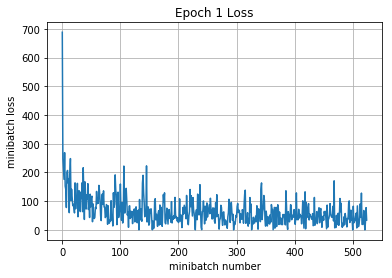

validation
Overall loss = 0.0162 and accuracy of 0.938
testing


In [10]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, shape=[None, 28*28], name='X')
y = tf.placeholder(tf.int64, shape=None, name='y')
is_training = tf.placeholder(tf.bool)

#### start build layer now
fc_1 = tf.layers.dense(X, 1024, 
                      activation=tf.nn.relu,
                      kernel_initializer=tf.contrib.layers.xavier_initializer(),
                      name='FC1')
y_out = tf.layers.dense(fc_1, 10, 
                       activation=None,
                       name='Y_OUT')

total_losses = tf.losses.softmax_cross_entropy(tf.one_hot(y, 10), logits=y_out)
#total_losses = tf.nn.softmax_cross_entropy_with_logits(logits=y_out, labels=y)

mean_loss = tf.reduce_mean(total_losses)

optimizer = tf.train.AdamOptimizer()
train_step = optimizer.minimize(mean_loss)

correct_predictions = tf.equal(tf.argmax(y_out, axis=1), y)
accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))

variables = [mean_loss, accuracy, correct_predictions, train_step]

batch_size = 64
epochs = 1
iter_cnt = 0
N = scale_x_train.shape[0]
with tf.Session() as sess:
    print('training')
    init = tf.global_variables_initializer()
    sess.run(init)

    for e in range(epochs):
        indices = np.arange(N)
        np.random.shuffle(indices)
        correct = 0
        losses = []
        for i in range(int(math.ceil(N / batch_size))):
            mask = indices[i*batch_size : (i+1)*batch_size]
            feed_dict = {
                X: scale_x_train[mask],
                y: y_train[mask],
            }
            actual_batch_size = len(mask)
            loss, acc, corr, _ = sess.run(variables, feed_dict=feed_dict)
            losses.append(loss*actual_batch_size)
            correct += np.sum(corr)
            if (iter_cnt % 100) == 0:
                print("Iteration {0}: with minibatch training loss = {1:.3g} and accuracy of {2:.2g}"\
                      .format(iter_cnt,loss,np.sum(corr)/actual_batch_size))
            iter_cnt += 1
        total_correct = correct/N
        total_loss = np.sum(losses)/N
        print("Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.3g}"\
              .format(total_loss,total_correct,e+1))
        if True:
            plt.plot(losses)
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e+1))
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()
    print('validation')
    val_variables = [total_losses, correct_predictions]
    total_loss = 0
    total_correct = 0
    for i in range(int(math.ceil(scale_x_val.shape[0]/batch_size))):
        feed_dict = {
            X:scale_x_val[i*batch_size:(i+1)*batch_size],
            y:y_val[i*batch_size:(i+1)*batch_size]
        }
        actual_batch_size = y_val[i*batch_size:(i+1)*batch_size].shape[0]
        loss, acc = sess.run(val_variables, feed_dict=feed_dict)
        total_loss += loss
        total_correct += np.sum(acc)
    total_loss /= scale_x_val.shape[0]
    total_correct /= scale_x_val.shape[0]
    print("Overall loss = {0:.3g} and accuracy of {1:.3g}"\
              .format(total_loss,total_correct))
    print('testing')
    val_variables = [y_out]
    for i in range(int(math.ceil(test.shape[0]/batch_size))):
        feed_dict = {
            X:test[i*batch_size:(i+1)*batch_size],
        }
        ## return a list
        out = sess.run(val_variables, feed_dict=feed_dict)
        OUTPUT.extend(list(np.argmax(out[0], axis=1)))

although we got the loss and accuracy in train data, <br>
but without a class or model , we had to train again on test data <br>
which cost a mount of computation

## Now try to build the graph in class in order to achieve reduced coupling

In [16]:
class Model:
    def __init__(self, lr=0.001):
        self.X = tf.placeholder(tf.float32, shape=(None, 28, 28, 1))
        self.y = tf.placeholder(tf.int64, shape=(None))
        self.is_training = tf.placeholder(tf.bool)
        self.step= tf.placeholder(tf.int32)
        self.lr = lr
        self.build_model()
    def build_model(self):
        conv_1 = tf.layers.conv2d(self.X, 64, 3, strides=(1, 1), padding='same', 
                                  activation=tf.nn.relu, 
                                  kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn_1 = tf.layers.batch_normalization(conv_1)
        dp_1 = tf.layers.dropout(bn_1)
        conv_2 = tf.layers.conv2d(dp_1, 128, 3, strides=(1, 1), padding='same', 
                                  activation=tf.nn.relu, 
                                  kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn_2 = tf.layers.batch_normalization(conv_2)
        dp_2 = tf.layers.dropout(bn_2)
        mp_1 = tf.layers.max_pooling2d(dp_2, 2, 2)
        flatten = tf.reshape(mp_1, (-1, 14*14*128))
        fc_1 = tf.layers.dense(flatten, 1024, 
                               activation=tf.nn.relu, 
                               kernel_initializer=tf.contrib.layers.xavier_initializer())
        dp_3 = tf.layers.dropout(fc_1)
        self.y_out = tf.layers.dense(dp_3, 10, 
                               activation=None,
                               kernel_initializer=tf.contrib.layers.xavier_initializer())
        print(self.y_out.shape, self.y.shape)
        loss = tf.nn.softmax_cross_entropy_with_logits(labels=tf.one_hot(self.y, 10), logits=self.y_out)
        self.mean_loss = tf.reduce_mean(loss)
        optimizer = tf.train.AdamOptimizer(self.lr)
        self.train_step = optimizer.minimize(self.mean_loss)
        correction = tf.equal(tf.argmax(self.y_out, axis=1), self.y)
        self.accuracy = tf.reduce_mean(tf.cast(correction, tf.float32))

In [18]:
class Solver:
    def __init__(self, sess, model, data, 
                 epochs=1, batch_size=64, 
                 is_training=True, 
                 print_every=100, plot_loss=False):
        self.sess = sess
        tf.set_random_seed(42)
        self.model = model
        self.Xt = data['X_train']
        self.yt = data['y_train']
        self.epochs = epochs
        self.batch_size = batch_size
        self.is_training = is_training
        self.print_every = print_every
        self.plot_loss = plot_loss
        self.sess.run(tf.global_variables_initializer())
        self.losses = []
    def predict(self, X_test):
        N = X_test.shape[0]
        variables = [self.model.y_out]
        out = []
        for i in range(int(math.ceil(N/self.batch_size))):
            feed_dict = {
                self.model.X: X_test[i*self.batch_size:(i+1)*self.batch_size].reshape((-1, 28, 28, 1))
            }
            y_out = sess.run(variables, feed_dict=feed_dict)
            out.extend(np.argmax(y_out[0], axis=1))
            #print(y_out)
        return out
            
            
    def train(self):
        self.losses = []
        iter_cnt = 0
        seed = 42
        N = self.Xt.shape[0]
        np.random.seed(seed+iter_cnt)
        variables = [self.model.mean_loss, self.model.accuracy, self.model.train_step]
        for e in range(self.epochs):
            train_indices = np.arange(N)
            np.random.shuffle(train_indices)
            losses = []
            corrects = 0
            for i in range(int(math.ceil(N/self.batch_size))):
                mask = train_indices[i*self.batch_size : (i+1)*self.batch_size]
                actual_size = len(mask)
                feed_dict = {
                    self.model.X: self.Xt[mask,:].reshape((-1, 28, 28, 1)),
                    self.model.y: self.yt[mask],
                    self.model.is_training:self.is_training,
                    self.model.step: iter_cnt
                }
                loss, acc, _ = self.sess.run(variables, feed_dict=feed_dict)
                losses.append(loss*actual_size)
                corrects += acc * actual_size
                if (iter_cnt % self.print_every) == 0:
                    print("Iteration {0}: with minibatch training loss = {1:.3g} and accuracy of {2:.2g}"\
                      .format(iter_cnt,loss,acc))
                iter_cnt += 1
            corrects /= N 
            self.losses.append(losses)
            print("Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.3g}"\
                  .format(np.sum(losses) / N,corrects,e+1))
            if self.plot_loss:
                plt.plot(losses)
                plt.grid(True)
                plt.title('Epoch {} Loss'.format(e+1))
                plt.xlabel('minibatch number')
                plt.ylabel('minibatch loss')
                plt.show()

In [19]:
data_dict = {
    'X_train': scale_x_train,
    'y_train': y_train,
    'X_val': scale_x_val,
    'y_val': y_val
}

(?, 10) <unknown>
Iteration 0: with minibatch training loss = 2.86 and accuracy of 0.031
Iteration 100: with minibatch training loss = 0.0266 and accuracy of 1
Iteration 200: with minibatch training loss = 0.0944 and accuracy of 0.97
Iteration 300: with minibatch training loss = 0.146 and accuracy of 0.95
Iteration 400: with minibatch training loss = 0.0133 and accuracy of 1
Iteration 500: with minibatch training loss = 0.175 and accuracy of 0.98
Epoch 1, Overall loss = 0.267 and accuracy of 0.95


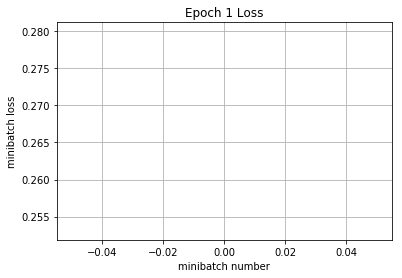

Iteration 600: with minibatch training loss = 0.0178 and accuracy of 1
Iteration 700: with minibatch training loss = 0.0174 and accuracy of 0.98
Iteration 800: with minibatch training loss = 0.0209 and accuracy of 1
Iteration 900: with minibatch training loss = 0.0543 and accuracy of 0.98
Iteration 1000: with minibatch training loss = 0.0388 and accuracy of 0.98
Epoch 2, Overall loss = 0.0399 and accuracy of 0.987


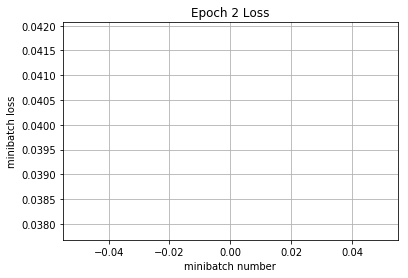

Iteration 1100: with minibatch training loss = 0.0119 and accuracy of 1
Iteration 1200: with minibatch training loss = 0.0159 and accuracy of 1
Iteration 1300: with minibatch training loss = 0.105 and accuracy of 0.98
Iteration 1400: with minibatch training loss = 0.000955 and accuracy of 1
Iteration 1500: with minibatch training loss = 0.00978 and accuracy of 1
Epoch 3, Overall loss = 0.0224 and accuracy of 0.993


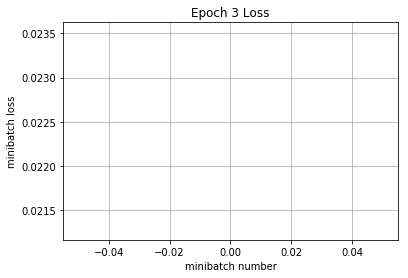

Iteration 1600: with minibatch training loss = 0.00584 and accuracy of 1
Iteration 1700: with minibatch training loss = 0.0344 and accuracy of 0.98
Iteration 1800: with minibatch training loss = 0.00929 and accuracy of 1
Iteration 1900: with minibatch training loss = 0.0741 and accuracy of 0.97
Iteration 2000: with minibatch training loss = 0.0101 and accuracy of 1
Epoch 4, Overall loss = 0.0209 and accuracy of 0.993


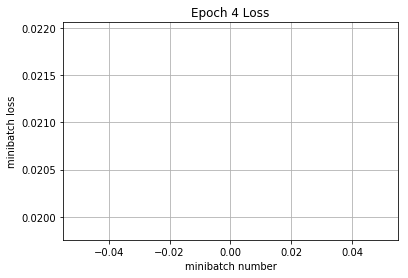

Iteration 2100: with minibatch training loss = 0.00974 and accuracy of 1
Iteration 2200: with minibatch training loss = 0.000802 and accuracy of 1
Iteration 2300: with minibatch training loss = 0.0406 and accuracy of 0.98
Iteration 2400: with minibatch training loss = 0.0219 and accuracy of 0.98
Iteration 2500: with minibatch training loss = 0.0156 and accuracy of 0.98
Iteration 2600: with minibatch training loss = 0.00248 and accuracy of 1
Epoch 5, Overall loss = 0.0179 and accuracy of 0.994


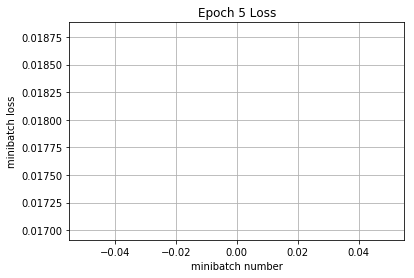

In [30]:
tf.reset_default_graph()
sess = tf.Session()
model = Model()
c_r_b_solver = Solver(sess, model, data_dict, epochs=5, plot_loss=True)
c_r_b_solver.train()

In [32]:
y_val_pre = solver.predict(scale_x_val.values)
acc = np.mean(y_val_pre == y_val)

In [43]:
print(acc)

0.981071428571


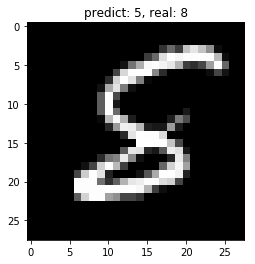

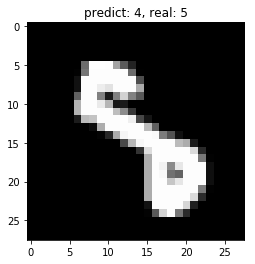

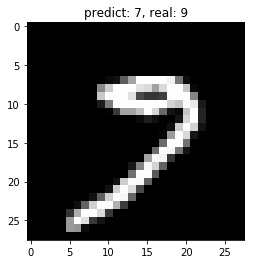

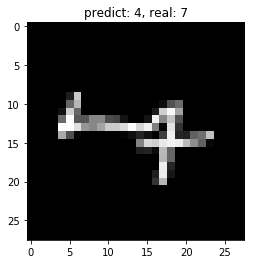

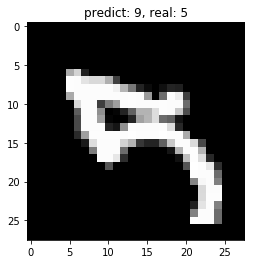

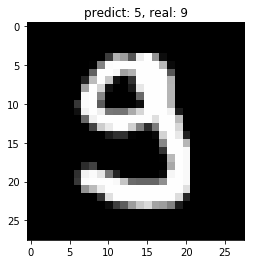

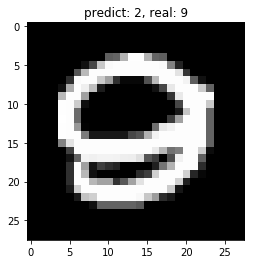

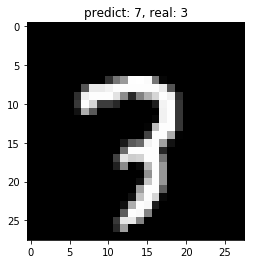

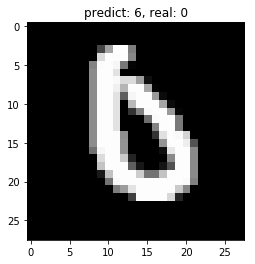

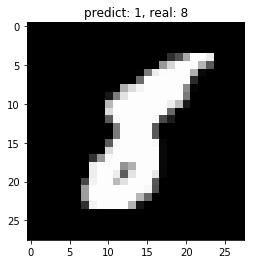

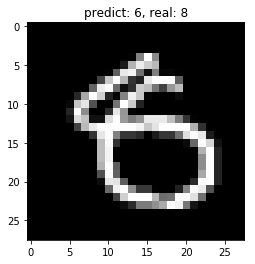

In [42]:
cnt = 0
for idx, item in enumerate(y_val_pre == y_val):
    if item is False and cnt <= 10:
        plt.imshow(X_val.values[idx, :].reshape(28, 28))
        plt.title('predict: {}, real: {}'.format(y_val_pre[idx], y_val.values[idx]))
        plt.show()
        cnt += 1

### in kaggle, we got 95% accuray, this was really creazy for the simple model
### the model is conv-relu-bn-maxpool-fc-fc
### in future, we'll try some complex model or tune the hypeparameters to achieve high scores
### then ,we tried another model
### conv-relu-bn-dp-mp-conv-relu-bn-dp-mp-fc-dp-fc
### and we achieved arruracy of 0.97171
### We had shown the error image in validation, some human errors and some model error
### the reason  caused what i had thinked was the less of data and the model not learned any
### details of corrner

In [44]:
OUTPUT = solver.predict(test)
out_put()

over


In [28]:
sess.close()

#### do some test about conv-relu-bn and conv-bn-relu

In [21]:
### base model conv-relu-bn-drop
class C_R_B_Model(Model):
    def build_model(self):
        conv_1 = tf.layers.conv2d(self.X, 64, 3, strides=(1, 1), padding='same', 
                                  activation=tf.nn.relu, 
                                  kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn_1 = tf.layers.batch_normalization(conv_1)
        mp_1 = tf.layers.max_pooling2d(bn_1, 2, 2)
        flatten = tf.reshape(mp_1, (-1, 14*14*64))
        self.y_out = tf.layers.dense(flatten, 10, 
                               activation=None, 
                               kernel_initializer=tf.contrib.layers.xavier_initializer())
        print(mp_1.shape, self.y_out.shape, self.y.shape)
        loss = tf.nn.softmax_cross_entropy_with_logits(labels=tf.one_hot(self.y, 10), logits=self.y_out)
        self.mean_loss = tf.reduce_mean(loss)
        optimizer = tf.train.AdamOptimizer(self.lr)
        self.train_step = optimizer.minimize(self.mean_loss)
        correction = tf.equal(tf.argmax(self.y_out, axis=1), self.y)
        self.accuracy = tf.reduce_mean(tf.cast(correction, tf.float32))

### conv-bn-relu-drop
class C_B_R_Model(Model):
    def build_model(self):
        conv_1 = tf.layers.conv2d(self.X, 64, 3, strides=(1, 1), padding='same', 
                                  activation=None, 
                                  kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn_1 = tf.layers.batch_normalization(conv_1)
        rl_1 = tf.nn.relu(bn_1)
        mp_1 = tf.layers.max_pooling2d(bn_1, 2, 2)
        flatten = tf.reshape(mp_1, (-1, 14*14*64))
        self.y_out = tf.layers.dense(flatten, 10, 
                               activation=None, 
                               kernel_initializer=tf.contrib.layers.xavier_initializer())
        print(mp_1.shape, self.y_out.shape, self.y.shape)
        loss = tf.nn.softmax_cross_entropy_with_logits(labels=tf.one_hot(self.y, 10), logits=self.y_out)
        self.mean_loss = tf.reduce_mean(loss)
        optimizer = tf.train.AdamOptimizer(self.lr)
        self.train_step = optimizer.minimize(self.mean_loss)
        correction = tf.equal(tf.argmax(self.y_out, axis=1), self.y)
        self.accuracy = tf.reduce_mean(tf.cast(correction, tf.float32))  
        
### conv-relu-drop-bn
class C_D_B_Model(Model):
    def build_model(self):
        conv_1 = tf.layers.conv2d(self.X, 64, 3, strides=(1, 1), padding='same', 
                                  activation=tf.nn.relu, 
                                  kernel_initializer=tf.contrib.layers.xavier_initializer())
        mp_1 = tf.layers.max_pooling2d(conv_1, 2, 2)
        bn_1 = tf.layers.batch_normalization(mp_1)
        flatten = tf.reshape(bn_1, (-1, 14*14*64))
        self.y_out = tf.layers.dense(flatten, 10, 
                               activation=None, 
                               kernel_initializer=tf.contrib.layers.xavier_initializer())
        print(mp_1.shape, self.y_out.shape, self.y.shape)
        loss = tf.nn.softmax_cross_entropy_with_logits(labels=tf.one_hot(self.y, 10), logits=self.y_out)
        self.mean_loss = tf.reduce_mean(loss)
        optimizer = tf.train.AdamOptimizer(self.lr)
        self.train_step = optimizer.minimize(self.mean_loss)
        correction = tf.equal(tf.argmax(self.y_out, axis=1), self.y)
        self.accuracy = tf.reduce_mean(tf.cast(correction, tf.float32))

### with learning decay
class LR_Decay_Model(Model):
    def build_model(self):
        conv_1 = tf.layers.conv2d(self.X, 64, 3, strides=(1, 1), padding='same', 
                                  activation=tf.nn.relu, 
                                  kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn_1 = tf.layers.batch_normalization(conv_1)
        mp_1 = tf.layers.max_pooling2d(bn_1, 2, 2)
        flatten = tf.reshape(mp_1, (-1, 14*14*64))
        self.y_out = tf.layers.dense(flatten, 10, 
                               activation=None, 
                               kernel_initializer=tf.contrib.layers.xavier_initializer())
        print(mp_1.shape, self.y_out.shape, self.y.shape)
        loss = tf.nn.softmax_cross_entropy_with_logits(labels=tf.one_hot(self.y, 10), logits=self.y_out)
        self.mean_loss = tf.reduce_mean(loss)
        lr = tf.train.exponential_decay(self.lr,
                                        global_step=self.step,
                                        decay_steps=10,decay_rate=0.9)
        optimizer = tf.train.AdamOptimizer(lr)
        self.train_step = optimizer.minimize(self.mean_loss)
        correction = tf.equal(tf.argmax(self.y_out, axis=1), self.y)
        self.accuracy = tf.reduce_mean(tf.cast(correction, tf.float32))

In [ ]:
tf.reset_default_graph()
sess = tf.Session()
crb_model = LR_Decay_Model()
crb_solver = Solver(sess, crb_model, data_dict, epochs=2, plot_loss=False)
print('crb model is training')
crb_solver.train()
y_val_pre = crb_solver.predict(scale_x_val.values)
acc = np.mean(y_val_pre == y_val)
print('crb model accuracy:',acc)
#cbr_model = C_B_R_Model()
#cbr_solver = Solver(sess, cbr_model, data_dict, epochs=2, plot_loss=False) 
#print('cbr model is training')
#cbr_solver.train()
cdb_model = C_D_B_Model()
cdb_solver = Solver(sess, cdb_model, data_dict, epochs=2, plot_loss=False)
print('cdb model is training')
cdb_solver.train()
y_val_pre = cdb_solver.predict(scale_x_val.values)
acc = np.mean(y_val_pre == y_val)
print('cdb model accuracy:',acc)

(?, 14, 14, 64) (?, 10) <unknown>
crb model is training
Iteration 0: with minibatch training loss = 3.13 and accuracy of 0.12


actually , even at accuracy or speed of convegence, 
conveconv-relu-bn is better than conv-bn-relu

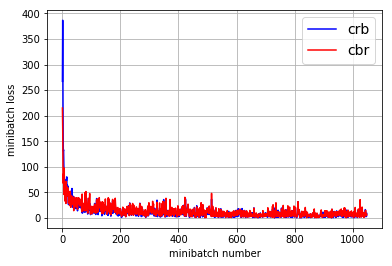

In [27]:
plt.subplot()
plt.plot(crb_solver.losses[0] + crb_solver.losses[1], 'b', label='crb')
plt.plot(cbr_solver.losses[0] + cbr_solver.losses[1], 'r', label='cbr')
plt.legend(loc='upper right', fontsize=14)
plt.grid(True)
plt.xlabel('minibatch number')
plt.ylabel('minibatch loss')
plt.show()

## there's even no difference between bn-mp or mp-bn

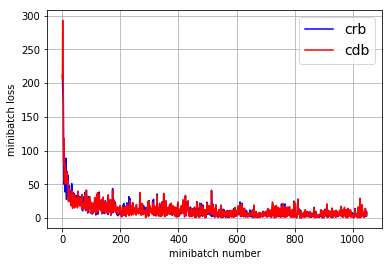

In [36]:
plt.subplot()
plt.plot(crb_solver.losses[0] + crb_solver.losses[1], 'b', label='crb')
plt.plot(cdb_solver.losses[0] + cdb_solver.losses[1], 'r', label='cdb')
plt.legend(loc='upper right', fontsize=14)
plt.grid(True)
plt.xlabel('minibatch number')
plt.ylabel('minibatch loss')
plt.show()

In [32]:
sess.close()

## data augmentation
#### first, implement some functions

In [79]:
import matplotlib.image as mpimg

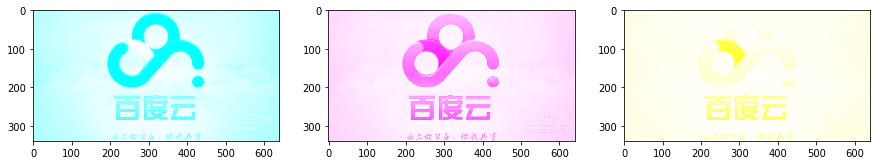

In [80]:
img = mpimg.imread('/tmp/a') / 255
plt.figure(figsize=(15, 45))
for idx in range(3):
    plt.subplot(1, 3, idx+1)
    new_img = np.ones(img.shape)
    new_img[:, :, idx] = img[:, :, idx]
    plt.imshow(new_img)

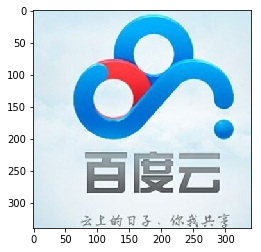

In [82]:
plt.imshow(img[:, 130:470, :])

In [95]:
from data_augmentation.utils import *

#### shape resize

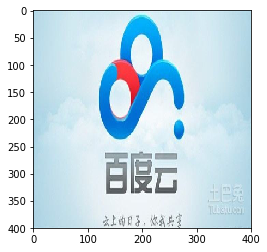

In [85]:
new_img = tf_resize_images(['/tmp/a'], image_size=400) /255
plt.imshow(new_img[0])

In [88]:
print(new_img.shape)

(1, 400, 400, 3)


#### scale

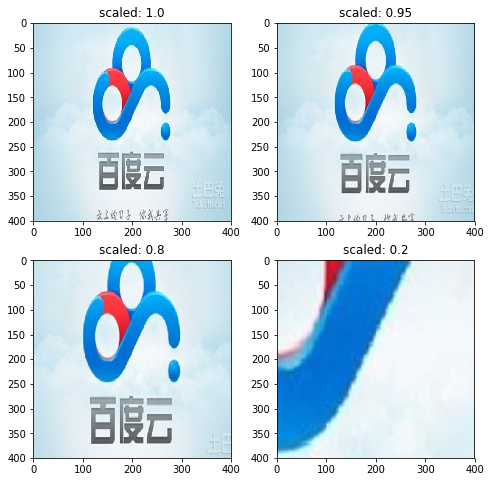

In [89]:
plt.figure(figsize=(8, 8))
scales = [1.0, 0.95, 0.8, 0.2]
for idx, value in enumerate(central_scale_images(new_img, scales, 400)):
    plt.subplot(2, 2, idx+1)
    plt.imshow(value)
    plt.title('scaled: {}'.format(scales[idx]))

#### translate 20% of image_size in all directions

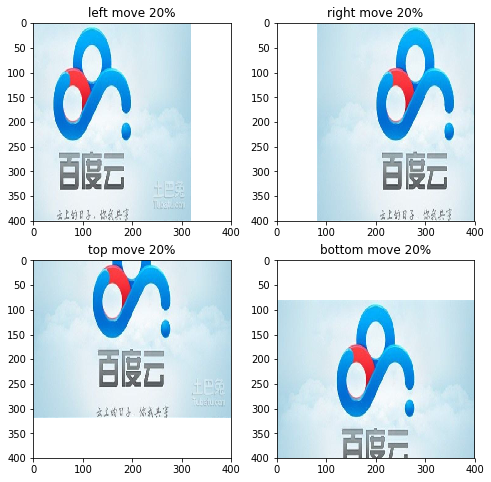

In [90]:
dirction = ['left move 20%', 'right move 20%', 'top move 20%', 'bottom move 20%']
plt.figure(figsize=(8, 8))
for idx, value in enumerate(translate_images(new_img)):
    plt.subplot(2, 2, idx+1)
    plt.imshow(value)
    plt.title('{}'.format(dirction[idx]))

#### rotate 90 degree

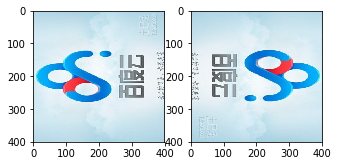

In [94]:
plt.figure(figsize=(8, 8))
for idx, value in enumerate(rotate_images(new_img, [1, 3])):
    plt.subplot(1, 3, idx+1)
    plt.imshow(value)

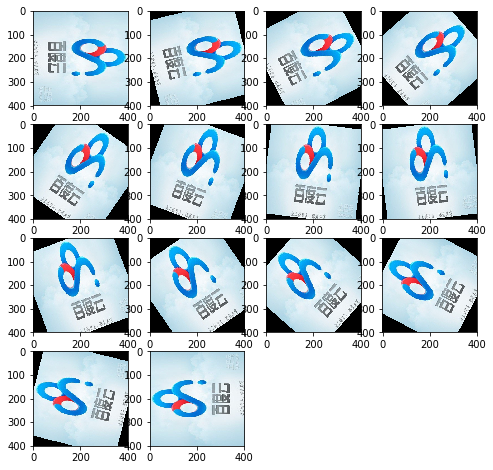

In [105]:
plt.figure(figsize=(8, 8))
for idx, value in enumerate(rotate_images_by_angle(new_img, -90, 90, 14)):
    plt.subplot(4, 4, idx+1)
    plt.imshow(value)